Michael Toolin<br>
Natural Language Processing<br>
DS 7337-403 <br>
Homework 8

In [2]:

""""
Created on Thu Apr3 19:06:23 2019

@author: mtool
"""
import sys; print ("Python", sys.version)
import nltk
#from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk import Tree
from pattern.en import parsetree, Chunk
import string
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup 
from statistics import mean, median

import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import requests
import re
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Python 3.6.6 |Anaconda custom (64-bit)| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mtool\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mtool\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mtool\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#
# Define functions used later
#
lemmer = nltk.stem.WordNetLemmatizer()
def LemTokens(tokens):
     return [lemmer.lemmatize(token) for token in tokens]
 
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
     return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))
#
# K-means function so we can iterate over number of clusters
#
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

### Movie genre selection and high level algorithm approach
I chose to examine reviews for the top 240 horror movies listed on the IMDB site. The following steps were used to scrape each page and find the permalink and eventually the review text for each movie. This algorithm needed to be changed from all the previous homeworks using this data. IMDb changed something on their webpages that broke my original algorithm.  I had to go back and re-write the webscraping algorithm that found the URLs for each movie.  Luckliy the other pages used did not change and th algorithm worked once I resolved this issue..<br>
 * I used the URL of this website to scrape the URL's for each individual movie.  These URLs are savedin a dictionary containing **{title:movieURL}**<br><br>
 * Within each movies page, I noticed the difference between the movies's main page and the user review page was the attribute on the end of the URL. All movie review pages had the same attribute. I created a new dictionary saving the user review URL **{title:reviewURL}**.<br><br>
 * Within each user review page a pattern was found identifying the permalink for each user review.<br> The review was downloaded and saved in it's own dictionary **{title:reviewText}**.<br><br>
 * Gather all the reviews and run the clustering algorithm on them. I run k-means clustering, checking to see what number of clusters from 2 to 10 give the best results.
 * Finally I reduce the dimenionality using PCA and plot the resulting clusters
 
 #### Get the URL for all 240 movies and save in dictionary titled reviewDict{}


In [4]:
#%%
#
# Top 240 horror movies @ https://www.imdb.com/list/ls059633855/
#
debug = False
movieCode = set ([])
pages = ['1','2','3']
reviewAttrb = 'reviews?ref_=tt_ql_3'
movieAttrb = '?ref_=ttls_li_tt'
reviewDict = {}

#
# Get all URL's from page of 240 horror movies listing.
# Each movie has multiple pages, but we want the one that has the
# attribute ?ref_=ttls_li_tt.
# NOTE!!! The above algorithm broke. We now are searching for href attribute
# that conatin the text '/title/tt'. Each movie contains two of these, the
# second href attribute contains the movie title. We keep only that one
# 
# Once we find these, get the title of the
# movie and then update the URL to point to the review page by replacing
# the attribute with reviews?ref_=tt_ql_3
# Create a dictionary of the movie titles and the URLs to user review pages
# Note this URL points to the page with ALL the reviews for the movie
#
# I noticed the page with user reviews for each movie uses the same URL
# but just passes a different attribute after the movie number. I don't have
# to go to each movie page to find the review page, just subst the attribute
# at the end to get to the user review pages
#
for pgNum in pages:
    urlStr='https://www.imdb.com/list/ls059633855/?sort=list_order,asc&st_dt=&mode=detail&page='+pgNum
    page = requests.get(urlStr)
    soup = BeautifulSoup(page.text,'html.parser')
    print("Getting movie page URL's in page {}".format(pgNum))
    for a in soup.find_all('a', href=re.compile('/title/tt')):
        if a['href'] in set(movieCode):
            if str(a.contents[0]) =='\n': continue
            if debug:
                print ("Found the URL:", a['href'],'for the movie', a.contents[0])
            revURL = a['href']+(reviewAttrb)
            revURL = 'https://www.imdb.com'+ revURL
            title = str(a.contents[0])
            reviewDict [title] = revURL
        else:
            movieCode.add(a['href'])
print('\nTotal of URLs found = ', len(reviewDict.keys()))

Getting movie page URL's in page 1
Getting movie page URL's in page 2
Getting movie page URL's in page 3

Total of URLs found =  241


#### Find the PermaLink URL for the first review for each movie
Store the PermaLink URL in the dictionary named permaDict{title:permaURL}

In [5]:
#%%
#
# Find first permaLink and create a dictionary 
# {Movie title:permaLink} This page has movie rankings by user, etc...
#
permaDict ={}
print ("Getting PermaLinks...\n")
for k in reviewDict:
    reviewURL = reviewDict.get(k)
    title = str(k)                             # Save title for key in new Dict
    reviewPage = requests.get(reviewURL)
    reviewSoup = BeautifulSoup(reviewPage.text, 'html.parser')
    permaTag = reviewSoup.find('a', href=re.compile('/review/rw')) 
    if debug:
        print('PermaLink review URL:', permaTag['href'],'for movie',k)  
    permaURL = 'https://www.imdb.com'+ permaTag['href']
    permaDict [title] = permaURL      

Getting PermaLinks...



#### Retrieve the body of each review and store in a dictionary textDict{title:reviewText}

In [6]:
#%%
#
# Retrieve the body of each each review and store in a dictionary
# {Title: Review Text}
#
textDict = {}
print('Getting review text... \n')
for k1 in permaDict:
    rawReviewText =''                           # Clear the buffer
    permaURL = permaDict.get(k1)
    title = str (k1)                            # Keep track of the movie title
    permaPage = requests.get(permaURL)
    permaSoup = BeautifulSoup(permaPage.text, 'html.parser')
    permaTag = permaSoup.find('div', {'class':'text show-more__control'})
    [p.replace_with(' ') for p in permaTag.findAll('br')]
    if debug:
        print(permaURL)
        print('Movie',k1, 'has text',permaTag.contents[0])
    for t in permaTag:
        rawReviewText = rawReviewText+ str(t)
    textDict[title] = rawReviewText

Getting review text... 



#### Create Tfidf vectors and features
Save the list of Movie titles in a list for easier access later. Since the IMDb website changes, the reviews that are being retrieved have changed also. I examined the key features being used for clustering and found the words *movie, movies, film, and films* were used to seperate the clusters.  These words are not providing any information so they have been added to the stop word list

In [7]:
#
# Create list of individual reviews
# Then create tfidf vectors and get feature names
#
listOfMyStopwords = ['movie','film','films','movies']
listOfReviews = []
listOfMovies = []
for k2 in textDict:
    listOfReviews.append(textDict.get(k2))
    listOfMovies.append(k2)
stopwordList = nltk.corpus.stopwords.words('english')+listOfMyStopwords
#tokenizer = RegexpTokenizer(r'\w+')
#TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words=stopwordList)
TfidfVec = TfidfVectorizer(stop_words=stopwordList)
tfidfReviewMatrix = TfidfVec.fit_transform(listOfReviews)
tfidfReviewFeatureNames = TfidfVec.get_feature_names()


#### Run the K-means clustering algorithm on the list of reviews.
I keep track of which number of clusters did the best job by checking the silhoutte score
and keeping track of that model.\n Looking at the silhoutte score reveals k = 3 clusters performed the best clustering on the data. However there was not any very good clustering of the reviews with any number of clusters with all silhoutte scores being below .005. The k=3 cluster barely performed better the k=2 or k=5. This may be due to the fact that each review is written by a different author so we are not finding alot commonality in the text.  What commonality we do find is most likely due to the all the reviews being written about the same genre of movies.

In [8]:
numOfClustersToTest = [2, 3, 4, 5, 6, 7, 8, 9 ,10]
bestCluster = 0                                 # Initalize this to zero
bestSilhoutteScore = 0
clusterListByMovie = []                                 # Use list of tuples to keep order
#
# Test which clustering size gives the densest clusters by checking 
# silhoutte scores
# Save the best clustering to analyze 
#
for nClusters in numOfClustersToTest:
    km = KMeans(n_clusters=nClusters, random_state=10,tol=.0001, max_iter=1000)
    clusterLabels = km.fit_predict(tfidfReviewMatrix)   
    silhouette_avg = metrics.silhouette_score(tfidfReviewMatrix, clusterLabels)
    sample_silhouette_values = metrics.silhouette_samples(tfidfReviewMatrix, 
                                                          clusterLabels)
    if silhouette_avg > bestSilhoutteScore:
        bestSilhoutteScore =  silhouette_avg
        bestCluster = nClusters
        bestKM = km
        clusters = km.labels_

#
# Graph and Print out the results
#
    
    print ('For {} clusters'.format(nClusters))
    print (Counter(km.labels_))
    print ('Silhoutte score:{:.6f}\n'.format(silhouette_avg))
    
print ('-'*20)
print('The best clustering was seen with {} clusters'.format(bestCluster))
#
# Build the cluster list of tuples such that (Movie,ClusterNumber)
# Use lists here rather than dictionaires because the order a dictionary
# is created is not guaranteed. 
#        
for i, k in enumerate (listOfMovies): clusterListByMovie.append((k,clusters[i]))
       

For 2 clusters
Counter({1: 234, 0: 7})
Silhoutte score:0.004203

For 3 clusters
Counter({1: 151, 2: 86, 0: 4})
Silhoutte score:0.001645

For 4 clusters
Counter({1: 126, 2: 72, 3: 39, 0: 4})
Silhoutte score:0.001296

For 5 clusters
Counter({1: 114, 4: 66, 3: 27, 0: 19, 2: 15})
Silhoutte score:0.001113

For 6 clusters
Counter({1: 72, 2: 64, 5: 45, 0: 29, 4: 26, 3: 5})
Silhoutte score:0.000961

For 7 clusters
Counter({6: 125, 4: 65, 0: 16, 3: 15, 2: 8, 1: 7, 5: 5})
Silhoutte score:0.001799

For 8 clusters
Counter({5: 56, 4: 45, 7: 45, 0: 30, 3: 29, 2: 16, 1: 13, 6: 7})
Silhoutte score:0.001396

For 9 clusters
Counter({1: 72, 4: 41, 6: 28, 5: 25, 3: 24, 0: 22, 2: 14, 8: 10, 7: 5})
Silhoutte score:0.001150

For 10 clusters
Counter({8: 68, 1: 64, 5: 30, 4: 18, 9: 14, 0: 13, 2: 12, 3: 11, 6: 6, 7: 5})
Silhoutte score:0.002215

--------------------
The best clustering was seen with 2 clusters


#### Question 2 - Characterize what each cluster is centered on semantically
It seems clear the **Cluster 0** is centered on Named Entities. This cluster only contains 4 books and the names Sarah, Juno and Musouka are charachters in the books this cluster. Also, the books *The Descent*, and *The Descent: Part 2* are most likely part of a series and is very likely some if not all of these names are in these books. This cluster also has other nouns which name people like *scientist* and *sheriff* so it makes sense that they are all put together.\n
**Cluster 1** and **Cluster 2** share some of the same features. Words like *film*, *movie*, *horror* and *story* are each features of both clusters. This makes it seem as if these two clusters have more in common than they do with **Cluster 0**.  The two features that distinguish **Cluster 1** from **Cluster 2** are *good* and *watch*. These features appear in **Cluster 2** and could mean these movies were more favorably rated then the movies in **Cluster 1**. A good next step would be tolook at the titles of these movies and compare user ratings to see if each cluster has similar user rating scores.

In [9]:
#
# Get cluster information into form for displaying
#
clusterInfo = {}
centers = bestKM.cluster_centers_.argsort()[:,::-1]
for clusterNum in range(bestCluster):
    movies = []
    clusterInfo[clusterNum] = {}
    clusterInfo[clusterNum]['clusterNum'] = clusterNum
    keyFeatures = [tfidfReviewFeatureNames[i] for i in centers[clusterNum,:10]]
    clusterInfo[clusterNum]['keyFeatures'] = keyFeatures
    for x, y in enumerate(clusterListByMovie):
        if clusterListByMovie[x][1] == clusterNum: movies.append(y[0])

    clusterInfo[clusterNum]['movies'] = movies
#
# Print out thge cluster information for the number of clusters with highest score.
#
for cluster_num, cluster_details in clusterInfo.items():
    print ('Cluster {} details:'.format(cluster_num))
    print ('-'*20)
    print ('Key features:', cluster_details['keyFeatures'])
    print ('Movies in this cluster:')
    print (', '.join(cluster_details['movies']))
    print ('='*40)  

Cluster 0 details:
--------------------
Key features: ['sarah', 'juno', 'woman', 'masuoka', 'cave', 'friends', 'family', 'starry', 'father', 'mutilation']
Movies in this cluster:
The Descent, Dans ma peau, The Woman, Starry Eyes, Marebito, The Descent: Part 2, Splice
Cluster 1 details:
--------------------
Key features: ['horror', 'one', 'like', 'story', 'well', 'good', 'really', 'characters', 'see', 'first']
Movies in this cluster:
The Wailing, 28 Days Later..., Let the Right One In, Busanhaeng, The Conjuring, Pitch Black, A Quiet Place, [Rec], The VVitch: A New-England Folktale, I Saw the Devil, It Follows, Insidious, Martyrs, The Mist, Sinister, Battle Royale, Saam gaang yi, Saw, A Tale of Two Sisters, Eden Lake, Split, The Devil's Rejects, House of 1000 Corpses, Trollhunter, Shutter, The Orphanage, It, The Others, The Hills Have Eyes, Drag Me to Hell, Southbound, Silent Hill, Noroi, The Babadook, 1408, Under the Shadow, Kairo, The Autopsy of Jane Doe, Baskin, Kokuhaku, The Devil's 

#### Reduce the dimensionality of the feature matrix
Here I reduce the dimensionality of the feature matrix to put it into a form that can be better visualized. Note that using 2 principal components each principal component explains nearly the same amount of variance. This is further evidence the our data is randomly scattered and not well clustered.

In [10]:
#
# Change tfidfReviewMatrix Sparse Matrix into a numpy matrix
# Reduce dimensionalty by create PCA matrix
#
tfpd = pd.DataFrame(tfidfReviewMatrix.todense())   
pca = PCA(n_components=2).fit(tfpd)  
tfpdPcaTransform = pca.fit_transform(tfpd)  
       
print ('\nThe vector for each Principle Component')
print ('---------------------------------------')
print('The vector for the First Principle Component is:{} \
      \nThe vector for the Second Principle Component is {}'.format(
      pca.components_[0],pca.components_[1]))

print ('\nThe variance explained by each Principle Component')
print ('-----------------------------------------------------')
print('The variance for the First Principle Component is:{} \
      \nThe variance for the Second Principle Component is {}'.format(
      pca.explained_variance_[0],pca.explained_variance_[1]))


The vector for each Principle Component
---------------------------------------
The vector for the First Principle Component is:[ 0.00122882 -0.00132897  0.03448237 ...  0.00156969 -0.000493
  0.00062914]       
The vector for the Second Principle Component is [-0.00368408  0.00043324  0.13165804 ...  0.00063595 -0.00089803
 -0.00132769]

The variance explained by each Principle Component
-----------------------------------------------------
The variance for the First Principle Component is:0.008356459438986741       
The variance for the Second Principle Component is 0.008243176008905182


#### Fit the K-means clustering model on the PCA matrix

In [11]:
kmeans = KMeans(n_clusters=bestCluster)
clusterLabels = kmeans.fit_predict(tfpdPcaTransform)
centroid = kmeans.cluster_centers_
labels = kmeans.labels_
print ('\nThe centroid coordinates for each group')
print ('-----------------------------------------')
print (centroid)


The centroid coordinates for each group
-----------------------------------------
[[-0.00827968 -0.00415512]
 [ 0.65685434  0.32963934]]


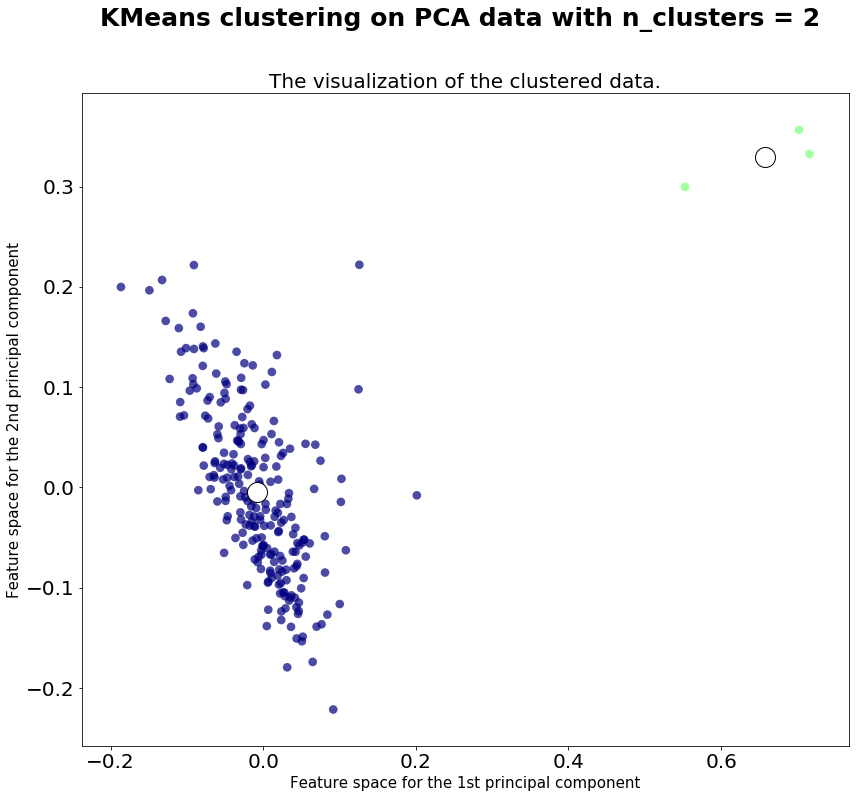

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
colors = cm.jet(clusterLabels.astype(float) / bestCluster)
ax.scatter(tfpdPcaTransform[:, 0], tfpdPcaTransform[:, 1], marker='.', s=300, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
ax.scatter(centers[:, 0], centers[:, 1],marker='o',
                c="white", alpha=1, s=400, edgecolor='k')

ax.set_title("The visualization of the clustered data.", fontsize=20)
ax.set_xlabel("Feature space for the 1st principal component", fontsize=15)
ax.set_ylabel("Feature space for the 2nd principal component", fontsize=15)

plt.suptitle(("KMeans clustering on PCA data "
              "with n_clusters = %d" % bestCluster),
            fontsize=25, fontweight='bold')
        
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

plt.show()

#### Load the VADER sentiment lexicon and find the sentiment for each review
The VADER ( Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and a rules based sentiment analysis library specifically aimeded at social media.  It is an open source library made available under the MIT Licences. It is a rules based library whose lexicon is made up of words known to be heavily used in social media. It goes beyond simple lexicon analysis to score text by using other parts of the review beyond words. VADER's ability to make sense of more than just words means we do not do the normal type of normalization on text before feeding into the analyer.  We want to make use of these features so we do not perform steps like removing punctuation, change to all lower case, or remove stop words. The followin list outlines some of VADER's features.

- *Punctuation* The use of an exclamation mark adds weight to sementic scoring of the phrases preceeding it. Multiple exclamation marks increse that weight
- *Capitalization*- The use all caps in a word for emphasis also increases the weight of the words in all caps
- *Conjunctions* - The word **but** signals VADER that the change in sentiment has occurred in the phrase will change the scoring of that phrase accordingly.
- *Preceding Tri-gram* - When the analysis finds a feature that has a high sentiment score, it will go back and re-examine the preceding Tr-gram. This helps identify negation flips in the polarity of the text.
- *Emoji's, Slang, Emoticons* - VADER can identify series of characters that are not words, but are used to convey sentiment in text such as social media. It uses thes to assign sentiment scores to the series of characters.

The section below uses VADER to score the reviews gathered from IMDB. The sentiment analysis of the first ten reviews are shown.
There is at least one review that seems to be positive which is rated negative. One possible reason for this is the genre of movie being reviewed is horror. It is likely that words used to describe a horror movie in a positve sense are weighted negatively in the lexicon. We would most likely have to heavily customize our lexicon to get accurate sentiment for words like *horror* and *mutilation*.

In [14]:
#
# Use the VADER lexicon
#
sid = SentimentIntensityAnalyzer()  
def analyzeSentimentVaderLex (review, threshold = 0.1, verbose = False):
#    tfPreProcess = TfidfVec.build_preprocessor()
#    cleanReview = tfPreProcess(review)
#    scores = sid.polarity_scores(cleanReview)
    scores = sid.polarity_scores(review)
    aggScore = scores['compound']
    finalSent = 'positive' if aggScore >threshold else 'negative'
    positive = str(round(scores['pos'],2)*100)+'%'
    final = round(aggScore, 2)
    negative = str(round(scores['neg'],2)*100)+'%'
    neutral = str(round(scores['neu'],2)*100)+'%'
    sentFrame = pd.DataFrame([[finalSent, final, positive,
                               negative, neutral]],
        columns=pd.MultiIndex(levels=[['SENTIMENT STATS:'], 
                                      ['Predicted Sentiment', 'Polarity Score',
                                       'Positive', 'Negative',
                                       'Neutral']], 
                              labels=[[0,0,0,0,0],[0,1,2,3,4]]))
    if verbose: print (sentFrame);
    return(scores, sentFrame)
    
# Look at a sample of Reviews
sampleOfReviews = listOfReviews[0:5]
for review in sampleOfReviews[:10]:
    print ('Review:')
    print (review)
    print ()
    analyzeSentimentVaderLex(review, threshold =0.0, verbose = True)
    print ('-'*60)

Review:
SPOILER: Have seen a lot of films, reviewed a lot of films but this extraordinary two and a half hour technically-perfect humanistic horror film from one of the finest writer/directors in the business (auteur of I SAW THE DEVIL) was something of a cipher.  The closest analog I can suggest in David Lynch's 2001's Mulholland Drive, yet another technically perfect, humanistic, suspense opus which keeps you captivated for its full length, yet has you walking out of the theatre shaking your head and wondering what exactly you just saw? Both film-makers understand the "big secret" of story telling which is, if you can present your story in such a way that the viewer feels he or she is sharing the experience with the protagonist, you can tell any story you like and the viewer will just keep going.  I will not even try to provide an explanation for what THE WAILING means, other than to re-quote the writer/director himself who, in numerous interviews on his film, said enigmatically "I b

#### Examine the key features of the clusters previously identified
The key features from each cluste are relatively neutral and don't provide much information about the senitment of each cluster. If we had a more custom lexicon as described above there may be a change in the sentiment of the different clusters.

In [15]:
print('-'*80)
print('{:10} {:10} {:10} {:10} {:10} '.format('Cluster#', 'Avg', 'Min',
     'Max','Median'))
print('-'*80)
for clusterNum in range(bestCluster):
    cluster = []
    for word in clusterInfo[clusterNum]['keyFeatures']:
        scores, sentiment = analyzeSentimentVaderLex(word, threshold = 0.0, 
                                                 verbose = False)
        cluster.append(scores['compound'])
    print('{:^10d} {:^1.4f}    {:^1.4f}     {:1.4f}    {:1.4f}\n Words: {}'.format(
            clusterNum, mean(cluster), min(cluster), max(cluster), 
            median(cluster), clusterInfo[clusterNum]['keyFeatures']))
    print('-'*80)
 


--------------------------------------------------------------------------------
Cluster#   Avg        Min        Max        Median     
--------------------------------------------------------------------------------
    0      0.0477    0.0000     0.4767    0.0000
 Words: ['sarah', 'juno', 'woman', 'masuoka', 'cave', 'friends', 'family', 'starry', 'father', 'mutilation']
--------------------------------------------------------------------------------
    1      0.0503    -0.5719     0.4404    0.0000
 Words: ['horror', 'one', 'like', 'story', 'well', 'good', 'really', 'characters', 'see', 'first']
--------------------------------------------------------------------------------
